In [1]:
# This module is to merge the RPPA and mRNA data, and divide the merged data into two subsets according to the levels of p-SHP2. 
# import all the packages used in this study
%matplotlib notebook
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
mpl.get_backend()
import matplotlib.pyplot as plt
import re

# import the raw_datasets
df_clinic=pd.read_csv("clinical_raw.csv", dtype=str).transpose()
df_mRNA=pd.read_csv("mRNA_raw.csv",dtype=str).dropna().transpose()
df_RPPA=pd.read_csv("RPPA_raw.csv",dtype=str).dropna().transpose()

# reset the header of each raw_datasets
df_clinic.columns=df_clinic.iloc[0]
df_clinic=df_clinic.drop("admin.batch_number", axis=0)
df_mRNA.columns=df_mRNA.iloc[0]
df_mRNA=df_mRNA.drop("Hybridization REF", axis=0).reset_index()
df_mRNA=df_mRNA.rename({"index":"Hybridization REF"}, axis="columns")
df_mRNA["Hybridization REF"]=[x.lower() for x in df_mRNA["Hybridization REF"]]
df_mRNA=df_mRNA.set_index("Hybridization REF")

df_RPPA.columns=df_RPPA.iloc[0]
df_RPPA=df_RPPA.drop("Composite.Element.REF",axis=0).reset_index()
df_RPPA=df_RPPA.rename({"index":"Composite.Element.REF"}, axis="columns")
df_RPPA["Composite.Element.REF"]=[x.lower() for x in df_RPPA["Composite.Element.REF"]]
df_RPPA=df_RPPA.set_index("Composite.Element.REF")

# select some columns interested in clinics data
col=["patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode", 
     "patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode","patient.samples.sample.bcr_sample_barcode"]
df_clinic_sub=df_clinic[col]

# Rename the columns to fit the mRNA and RPPA datasets
df_clinic_sub=df_clinic_sub.rename({"patient.samples.sample.portions.portion.analytes.analyte-2.aliquots.aliquot-2.bcr_aliquot_barcode":
                                   "Hybridization REF","patient.samples.sample.portions.shipment_portion.shipment_portion_bcr_aliquot_barcode":
                                   "Composite.Element.REF"}, axis="columns")
# set index of selected clinic data and merge with mRNA dataset

df_merge=pd.merge(df_clinic_sub,df_mRNA, how="outer", on="Hybridization REF").dropna()
df_merge=df_merge.reset_index()
df_merge=df_merge.set_index("Composite.Element.REF")
df_merge=pd.merge(df_merge, df_RPPA, how="outer", on="Composite.Element.REF").dropna()
df_merge_sub=df_merge.drop(["index","Hybridization REF","Composite Element REF","patient.samples.sample.bcr_sample_barcode"], axis=1)
df_merge_sub=df_merge_sub.astype(float)

#Divide the merged data into two subsets according to the levels of p-SHP2.
a=np.median(df_merge_sub["PTPN11|SHP-2_pY542"])
df_pSHP2_high=df_merge_sub.where(df_merge_sub["PTPN11|SHP-2_pY542"]>=a).dropna()
df_pSHP2_low=df_merge_sub.where(df_merge_sub["PTPN11|SHP-2_pY542"]<a).dropna()

# Output the two subsets into two csv files for ssGSEA analysis with R. 
df_pSHP2_high.to_csv("mRNA_pSHP2_high.csv")
df_pSHP2_low.to_csv("mRNA_pSHP2_low.csv")

<IPython.core.display.Javascript object>


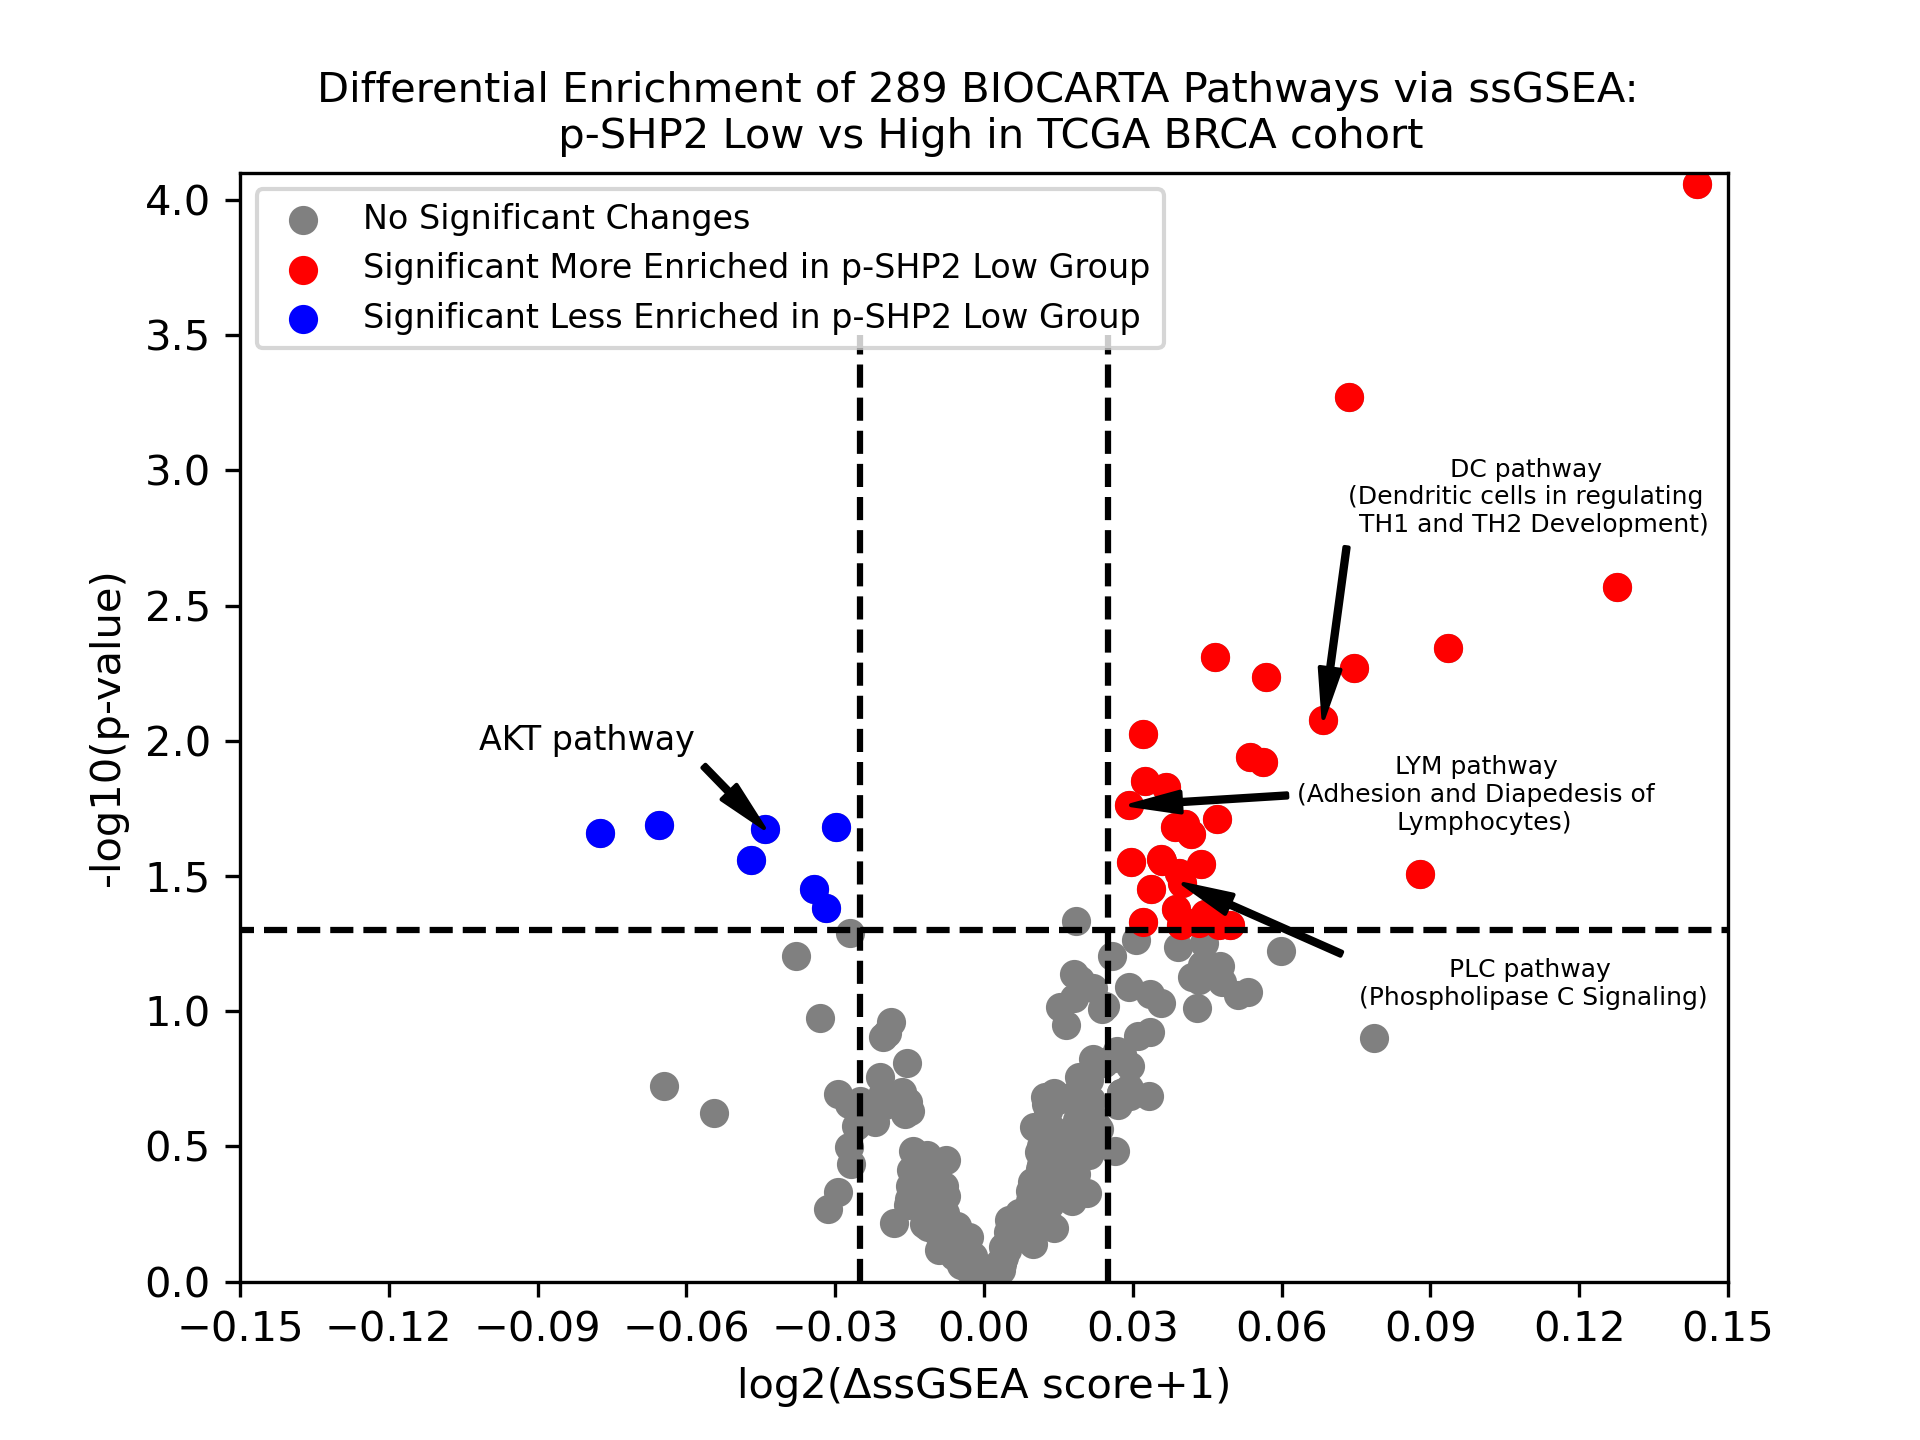

Text(-0.08, 2, 'AKT pathway')

In [4]:
# import the ssGSEA datasets produced by R. 
df_high=pd.read_csv("ssGSEAhigh2.csv", dtype=str, index_col=0).astype(float)
df_low=pd.read_csv("ssGSEAlow2.csv", dtype=str, index_col=0).astype(float)

# Calculate the difference of means of ssGSEA score between p-SHP2 low and high group. 
diff=df_low.aggregate(np.mean,1)-df_high.aggregate(np.mean,1)
diff=pd.DataFrame(diff)
diff=diff.set_axis(["difference"], axis=1)

# Calculate the p-value of the t-test between two groups in different pathways
p_value=[-np.log10((stats.ttest_ind(df_high.iloc[x],df_low.iloc[x],equal_var=False))[1]) for x in range(len(diff))]
diff=diff.assign(p_value=p_value)
diff=diff.sort_values(by="difference",ascending=True)
diff["log2(diff+1)"]=np.log2(diff["difference"]+1)
diff.loc["BIOCARTA_TCR_PATHWAY"]

# find the datasets with good difference and p-value. 
diff_up=diff.where((diff["log2(diff+1)"]>0.025)&(diff["p_value"]>1.3)).dropna()
diff_down=diff.where((diff["log2(diff+1)"]<-0.025)&(diff["p_value"]>1.3)).dropna()

# Plot the volcano plot
plt.figure(dpi=300)
plt.scatter(diff["log2(diff+1)"],diff["p_value"], c="grey")
plt.scatter(diff_up["log2(diff+1)"],diff_up["p_value"], c="red")
plt.scatter(diff_down["log2(diff+1)"],diff_down["p_value"], c="blue")
plt.gca().legend(["No Significant Changes","Significant More Enriched in p-SHP2 Low Group","Significant Less Enriched in p-SHP2 Low Group"],
                fontsize=8, facecolor="white", loc=2)
plt.plot([-0.2,0.2],[1.3,1.3],ls="--",c="black")
plt.plot([-0.025,-0.025],[0,3.5],ls="--",c="black")
plt.plot([0.025,0.025],[0,3.5],ls="--",c="black")
plt.xlim(-0.15,0.15)
plt.ylim(0,4.1)
plt.xticks([-0.15,-0.12,-0.09,-0.06,-0.03,0,0.03,0.06,0.09,0.12,0.15])
plt.gca().set_xlabel("log2(ΔssGSEA score+1)")
plt.gca().set_ylabel("-log10(p-value)")
plt.title("Differential Enrichment of 289 BIOCARTA Pathways via ssGSEA: \n p-SHP2 Low vs High in TCGA BRCA cohort", fontsize=10)
plt.gca().annotate('LYM pathway \n(Adhesion and Diapedesis of \n Lymphocytes)', xy=(0.029316, 1.761326),xytext=(0.10, 1.8),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('DC pathway \n(Dendritic cells in regulating \n TH1 and TH2 Development)', xy=(0.068379, 2.077467),xytext=(0.11, 2.9),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('PLC pathway\n (Phospholipase C Signaling)', xy=(0.039895, 1.472672),xytext=(0.11, 1.1),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('AKT pathway', xy=(-0.044230,1.674737),xytext=(-0.08, 2),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=8)

<IPython.core.display.Javascript object>


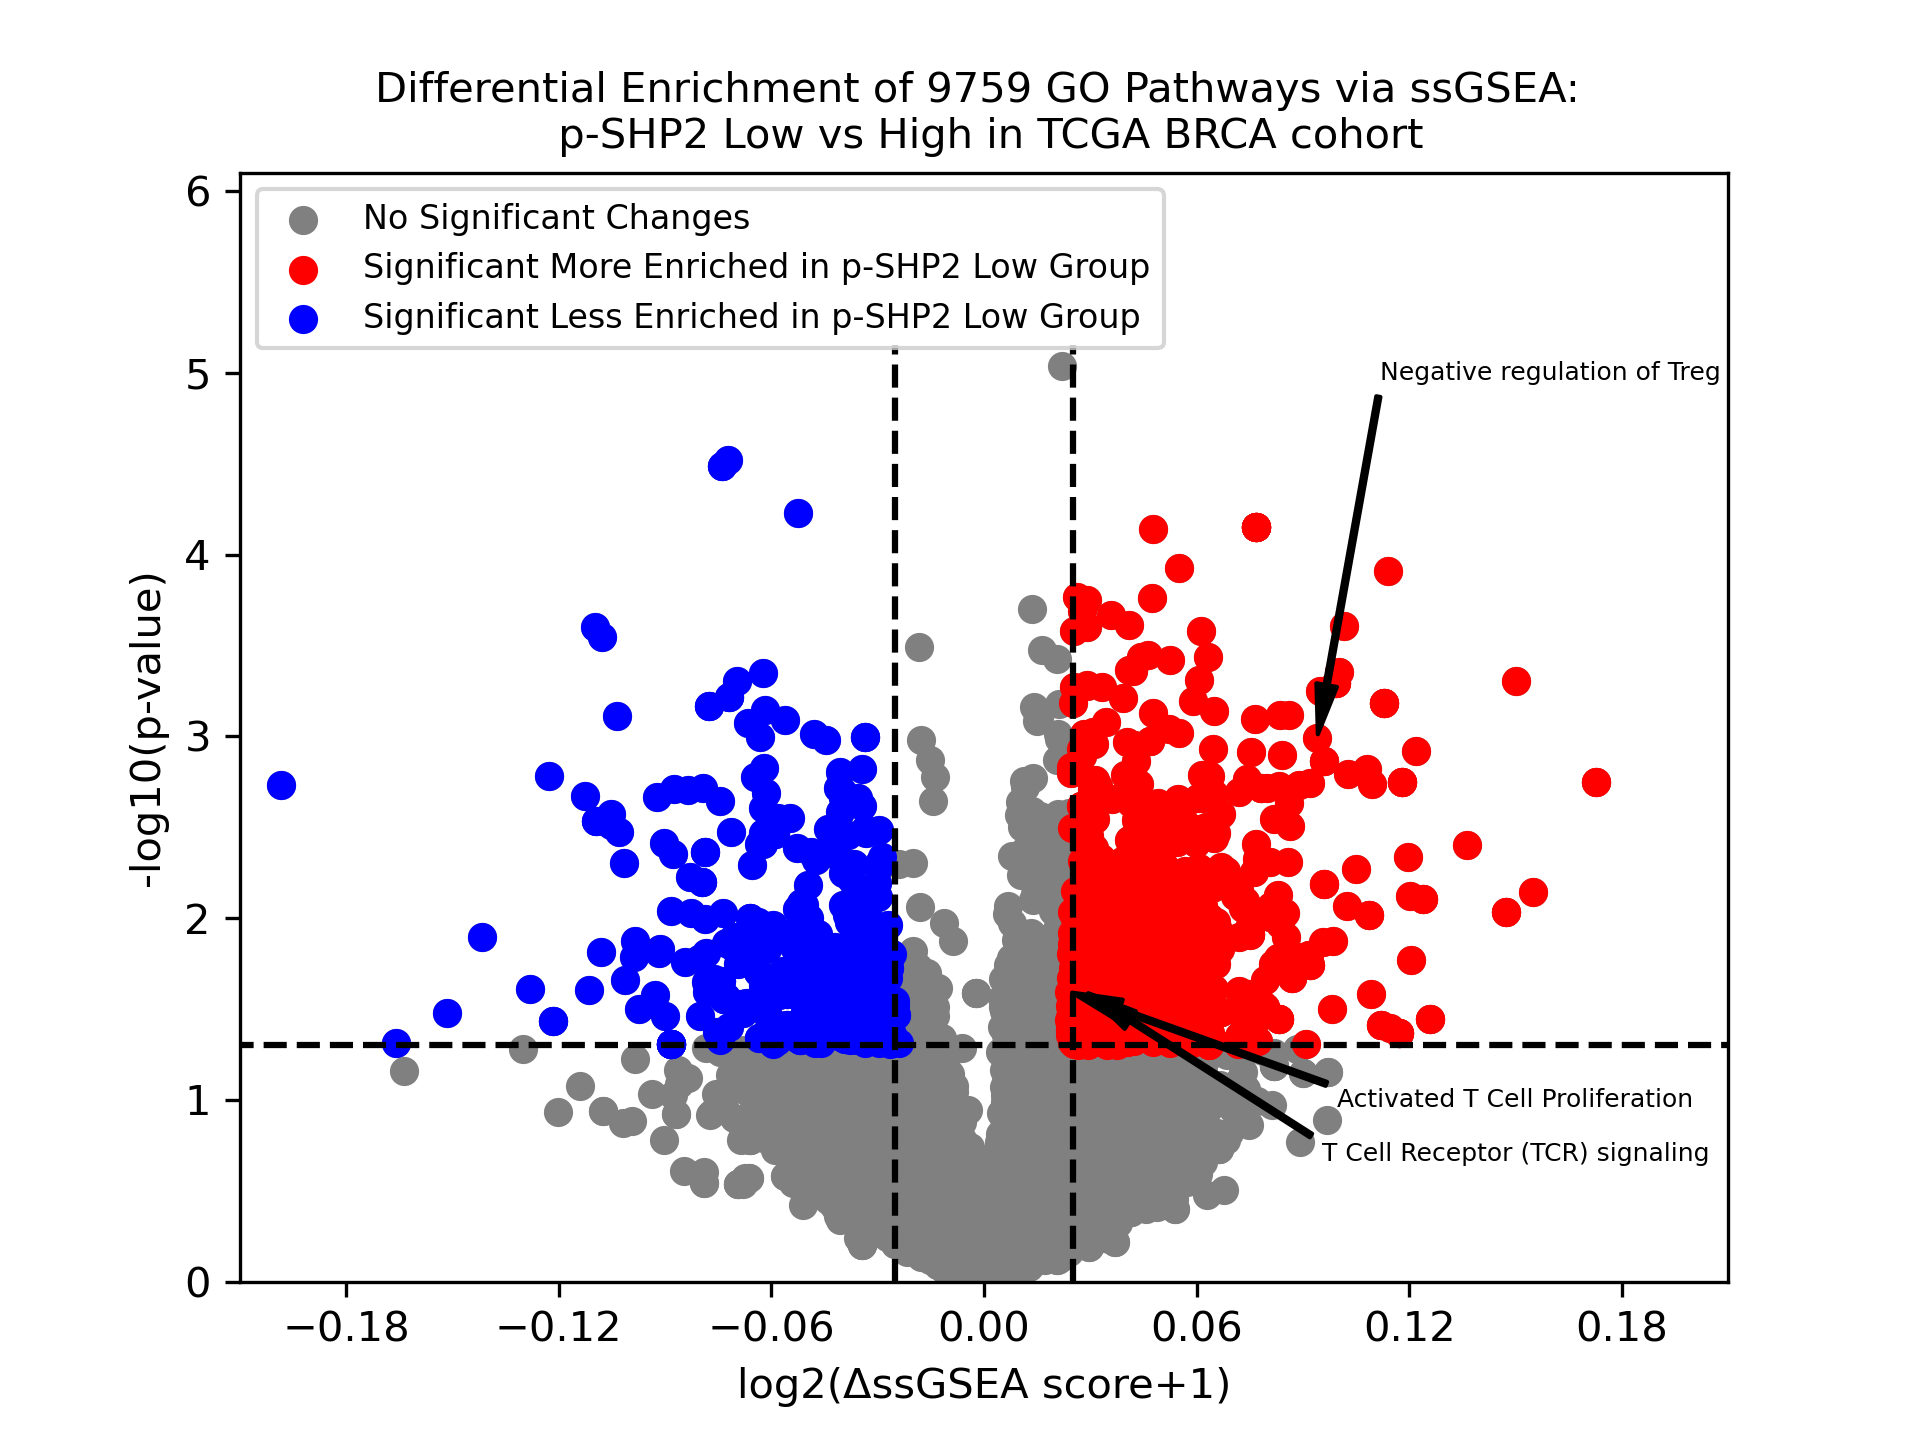

Text(0.15, 0.7, 'T Cell Receptor (TCR) signaling')

In [5]:
# import the raw_datasets
df_high=pd.read_csv("ssGSEAhigh_GO.csv", dtype=str, index_col=0).astype(float)
df_low=pd.read_csv("ssGSEAlow_GO.csv", dtype=str, index_col=0).astype(float)

# Calculate the difference of means of ssGSEA score between p-SHP2 low and high group. 
diff=df_low.aggregate(np.mean,1)-df_high.aggregate(np.mean,1)
diff=pd.DataFrame(diff)
diff=diff.set_axis(["difference"], axis=1)

# Calculate the p-value of the t-test between two groups in different pathways
p_value=[-np.log10((stats.ttest_ind(df_high.iloc[x],df_low.iloc[x],equal_var=False))[1]) for x in range(len(diff))]
diff=diff.assign(p_value=p_value)
diff=diff.sort_values(by="p_value",ascending=False)
diff["log2(diff+1)"]=np.log2(diff["difference"]+1)

diff_up=diff.where((diff["log2(diff+1)"]>0.024)&(diff["p_value"]>1.3)).dropna()
diff_down=diff.where((diff["log2(diff+1)"]<-0.024)&(diff["p_value"]>1.3)).dropna()

plt.figure(dpi=300)
plt.scatter(diff["log2(diff+1)"],diff["p_value"], c="grey")
plt.scatter(diff_up["log2(diff+1)"],diff_up["p_value"], c="red")
plt.scatter(diff_down["log2(diff+1)"],diff_down["p_value"], c="blue")
plt.gca().legend(["No Significant Changes","Significant More Enriched in p-SHP2 Low Group","Significant Less Enriched in p-SHP2 Low Group"],
                fontsize=8, facecolor="white", loc=2)
plt.plot([-0.25,0.25],[1.3,1.3],ls="--",c="black")
plt.plot([-0.025,-0.025],[0,5.15],ls="--",c="black")
plt.plot([0.025,0.025],[0,5.15],ls="--",c="black")
plt.xlim(-0.21,0.21)
plt.ylim(0,6.1)
plt.xticks([-0.18,-0.12,-0.06,0,0.06,0.12,0.18])
plt.gca().set_xlabel("log2(ΔssGSEA score+1)")
plt.gca().set_ylabel("-log10(p-value)")
plt.title("Differential Enrichment of 9759 GO Pathways via ssGSEA: \n p-SHP2 Low vs High in TCGA BRCA cohort", fontsize=10)
plt.gca().annotate('Negative regulation of Treg', xy=(0.094054, 2.991372),xytext=(0.16, 5),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('Activated T Cell Proliferation', xy=(0.024126, 1.595029),xytext=(0.15, 1.0),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('T Cell Receptor (TCR) signaling', xy=(0.028741, 1.595005),xytext=(0.15, 0.7),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)


<IPython.core.display.Javascript object>


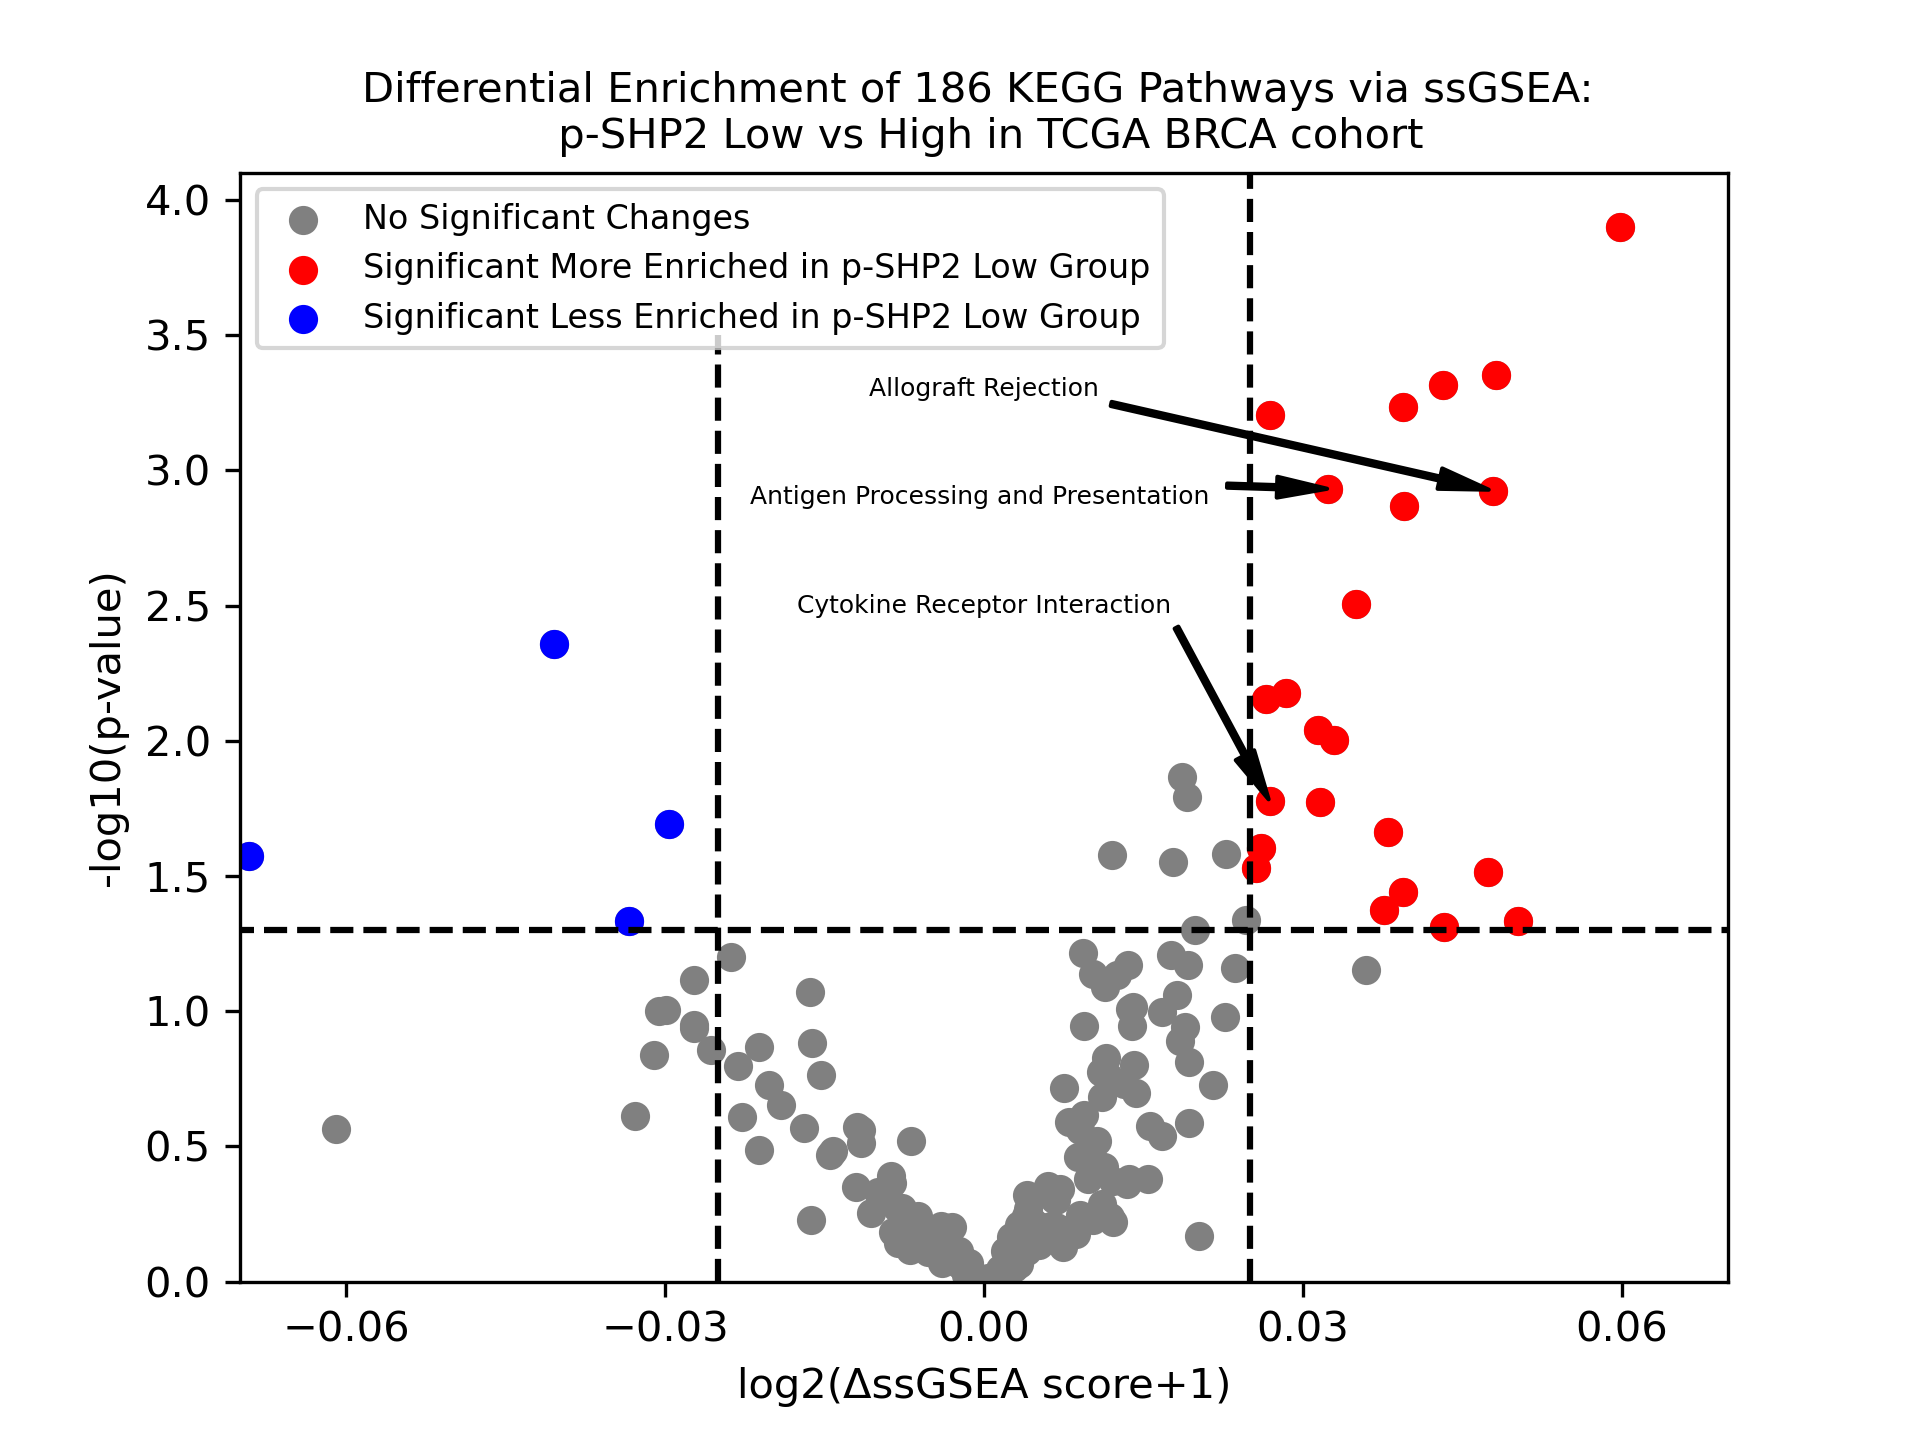

Text(0, 3.3, 'Allograft Rejection')

In [6]:
# import the raw_datasets
df_high=pd.read_csv("ssGSEAhigh_KEGG.csv", dtype=str, index_col=0).astype(float)
df_low=pd.read_csv("ssGSEAlow_KEGG.csv", dtype=str, index_col=0).astype(float)
diff=df_low.aggregate(np.mean,1)-df_high.aggregate(np.mean,1)
diff=pd.DataFrame(diff)
diff=diff.set_axis(["difference"], axis=1)
p_value=[-np.log10((stats.ttest_ind(df_high.iloc[x],df_low.iloc[x],equal_var=False))[1]) for x in range(len(diff))]

diff=diff.assign(p_value=p_value)
diff=diff.sort_values(by="difference",ascending=True)
diff["log2(diff+1)"]=np.log2(diff["difference"]+1)

diff_up=diff.where((diff["log2(diff+1)"]>0.025)&(diff["p_value"]>1.3)).dropna()
diff_down=diff.where((diff["log2(diff+1)"]<-0.025)&(diff["p_value"]>1.3)).dropna()
plt.figure(dpi=300)
plt.scatter(diff["log2(diff+1)"],diff["p_value"], c="grey")
plt.scatter(diff_up["log2(diff+1)"],diff_up["p_value"], c="red")
plt.scatter(diff_down["log2(diff+1)"],diff_down["p_value"], c="blue")
plt.gca().legend(["No Significant Changes","Significant More Enriched in p-SHP2 Low Group","Significant Less Enriched in p-SHP2 Low Group"],
                fontsize=8, facecolor="white", loc=2)
plt.plot([-0.2,0.2],[1.3,1.3],ls="--",c="black")
plt.plot([-0.025,-0.025],[0,3.5],ls="--",c="black")
plt.plot([0.025,0.025],[0,5.5],ls="--",c="black")
plt.xlim(-0.07,0.07)
plt.ylim(0,4.1)
plt.xticks([-0.06,-0.03,0,0.03,0.06])
plt.gca().set_xlabel("log2(ΔssGSEA score+1)")
plt.gca().set_ylabel("-log10(p-value)")
plt.title("Differential Enrichment of 186 KEGG Pathways via ssGSEA: \n p-SHP2 Low vs High in TCGA BRCA cohort", fontsize=10)
plt.gca().annotate('Cytokine Receptor Interaction', xy=(0.026869, 1.776743),xytext=(0, 2.5),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('Antigen Processing and Presentation ', xy=(0.032381, 2.931559),xytext=(0, 2.9),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('Allograft Rejection', xy=(0.047853, 2.924923),xytext=(0, 3.3),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)

<IPython.core.display.Javascript object>


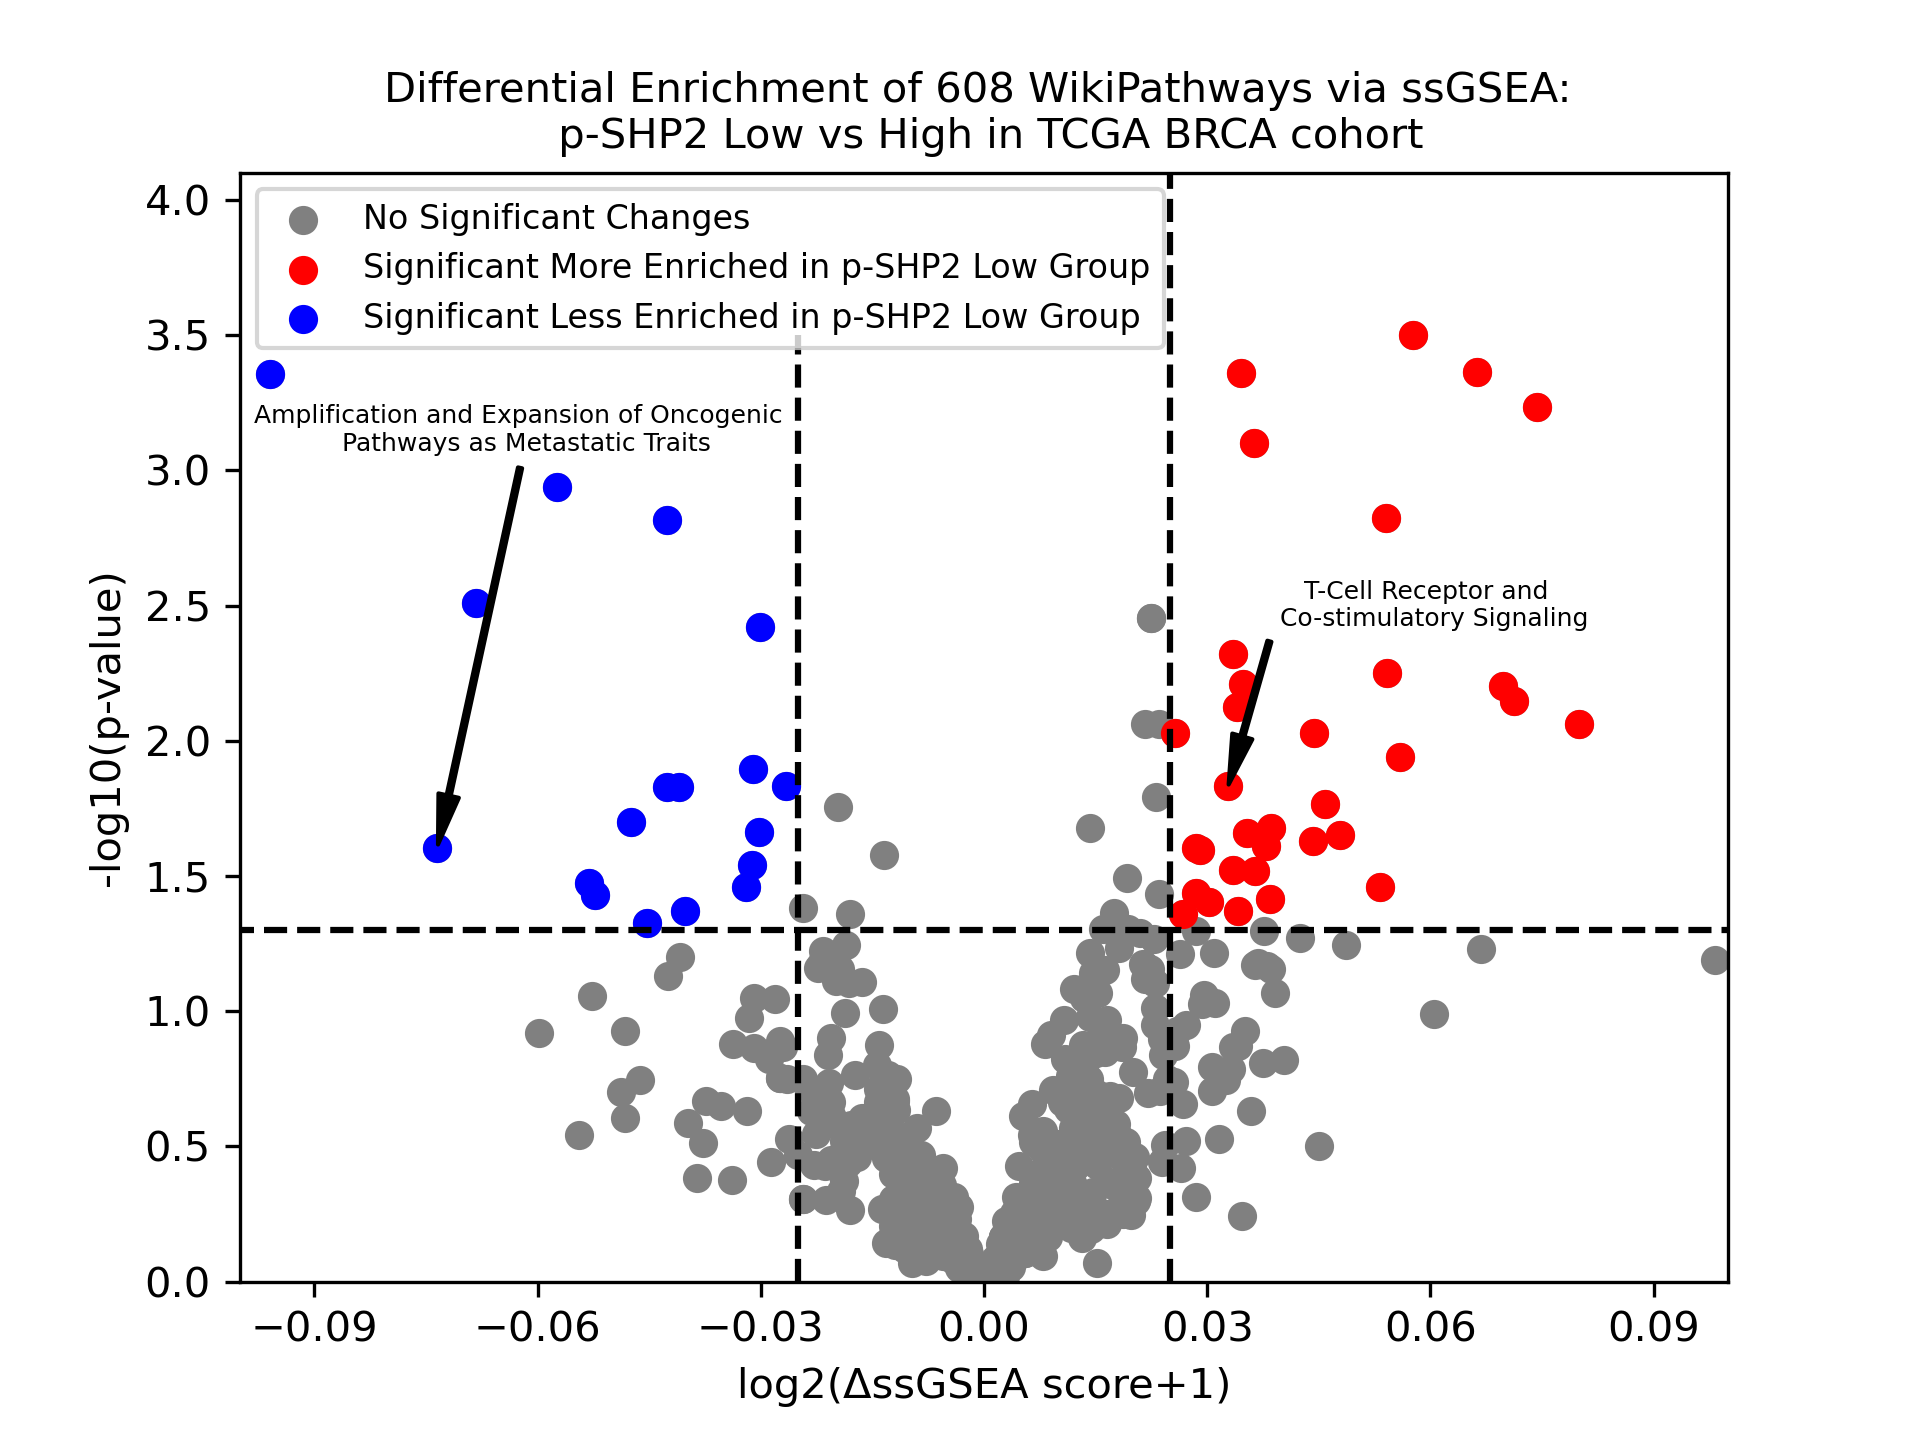

Text(-0.062, 3.15, 'Amplification and Expansion of Oncogenic \n Pathways as Metastatic Traits')

In [7]:
# import the raw_datasets
df_high=pd.read_csv("ssGSEAhigh_wiki.csv", dtype=str, index_col=0).astype(float)
df_low=pd.read_csv("ssGSEAlow_wiki.csv", dtype=str, index_col=0).astype(float)
diff=df_low.aggregate(np.mean,1)-df_high.aggregate(np.mean,1)
diff=pd.DataFrame(diff)
diff=diff.set_axis(["difference"], axis=1)
p_value=[-np.log10((stats.ttest_ind(df_high.iloc[x],df_low.iloc[x],equal_var=False))[1]) for x in range(len(diff))]

diff=diff.assign(p_value=p_value)
diff=diff.sort_values(by="difference",ascending=False)
diff["log2(diff+1)"]=np.log2(diff["difference"]+1)

diff_up=diff.where((diff["log2(diff+1)"]>0.025)&(diff["p_value"]>1.3)).dropna()
diff_down=diff.where((diff["log2(diff+1)"]<-0.025)&(diff["p_value"]>1.3)).dropna()

plt.figure(dpi=300)
plt.scatter(diff["log2(diff+1)"],diff["p_value"], c="grey")
plt.scatter(diff_up["log2(diff+1)"],diff_up["p_value"], c="red")
plt.scatter(diff_down["log2(diff+1)"],diff_down["p_value"], c="blue")
plt.gca().legend(["No Significant Changes","Significant More Enriched in p-SHP2 Low Group","Significant Less Enriched in p-SHP2 Low Group"],
                fontsize=8, facecolor="white", loc=2)
plt.plot([-0.2,0.2],[1.3,1.3],ls="--",c="black")
plt.plot([-0.025,-0.025],[0,3.5],ls="--",c="black")
plt.plot([0.025,0.025],[0,5.5],ls="--",c="black")
plt.xlim(-0.10,0.10)
plt.ylim(0,4.1)
plt.xticks([-0.09,-0.06,-0.03,0,0.03,0.06,0.09])
plt.gca().set_xlabel("log2(ΔssGSEA score+1)")
plt.gca().set_ylabel("-log10(p-value)")
plt.title("Differential Enrichment of 608 WikiPathways via ssGSEA: \n p-SHP2 Low vs High in TCGA BRCA cohort", fontsize=10)
plt.gca().annotate('T-Cell Receptor and \n Co-stimulatory Signaling', xy=(0.032823,1.832388),xytext=(0.06, 2.5),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)
plt.gca().annotate('Amplification and Expansion of Oncogenic \n Pathways as Metastatic Traits', xy=(-0.073501, 1.601843),xytext=(-0.062, 3.15),
            arrowprops=dict(width=1,headwidth=5,facecolor='black', shrink=0.01),
            horizontalalignment='center', verticalalignment='center', fontsize=6)